In [22]:
import os
import albumentations as albu
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import models
from tqdm import tqdm_notebook
import evaluate
from art.attacks.evasion import HopSkipJump
from art.estimators.classification import BlackBoxClassifier
from catalyst.contrib.layers import ArcFace
import matplotlib.pyplot as plt

### Download face_modelv10 from https://huggingface.co/DCEK/arcface/tree/main to reproduce experiment

In [9]:
device = torch.device("cuda")
class ArcResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ArcResNet50, self).__init__()
        self.model = models.resnet50(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, self.model.fc.in_features)
        self.head = ArcFace(self.model.fc.out_features, num_classes, s=13, m=0.15)
    def forward(self, x, targets=None):
        output = self.model(x)
        outputs = self.head(output, targets)
        return outputs

num_classes = 10000
    
model = ArcResNet50(num_classes=num_classes)
model.to(device)
model_path = '../CHAPTER_13/experiments/face_modelv10'
state_dict = torch.load(os.path.join(model_path, "model.last.pth"))
model.load_state_dict(state_dict)

<All keys matched successfully>

In [10]:
train = pd.read_csv('../CHAPTER_13/face_age_gender.csv')
image_path = train['image_path'].values
targets = train['target'].values
name2class = {name: idx for idx, name in enumerate(sorted(set(targets)))}
id_targets = np.array([name2class[target] for target in targets])

In [11]:
transforms = albu.Compose([
    albu.Resize(224, 224),
    albu.Normalize(),
    ToTensorV2()
])
def predict(x):
    if len(x.shape) == 3:
        img = transforms(image=x)["image"].unsqueeze(0).to(device)
    else:
        batch_img = []
        for img in x:
            img = transforms(image=img)["image"].to(device)
            batch_img.append(img)
        img = torch.stack(batch_img)
    with torch.inference_mode():
        output = model(img)
    return output.cpu().numpy()

In [16]:
target_image = np.array(
    Image.open(os.path.join("../CHAPTER_13", image_path[1])).resize((224, 224))
).astype(np.float32)
classifier = BlackBoxClassifier(predict, target_image.shape, num_classes, clip_values=(0, 255))


In [17]:
attack = HopSkipJump(classifier=classifier, targeted=False, max_iter=10, max_eval=1000, init_eval=10)


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

class label 7803.


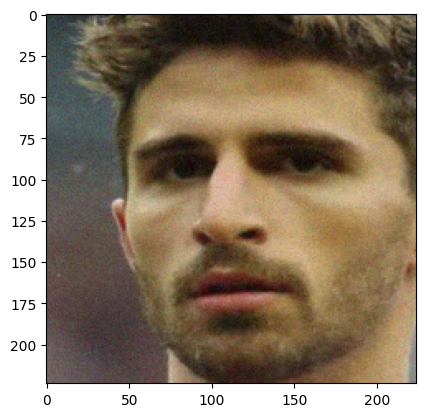

-32.93457 31.961937
5369
5369


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

class label 7803.


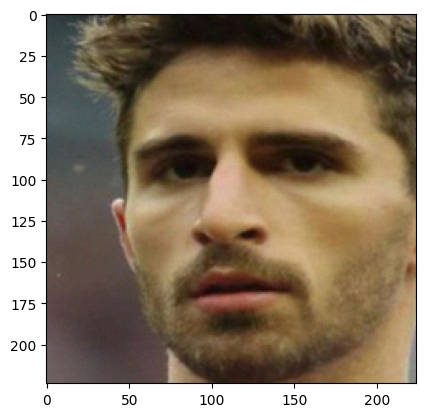

-11.074722 10.416031
5369
5369


HopSkipJump:   0%|          | 0/1 [00:00<?, ?it/s]

class label 5187.


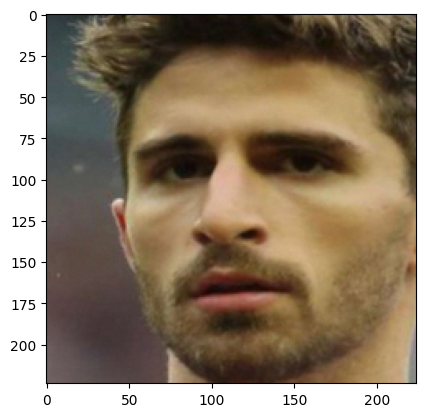

-6.6168213 6.7382812
5369
5369


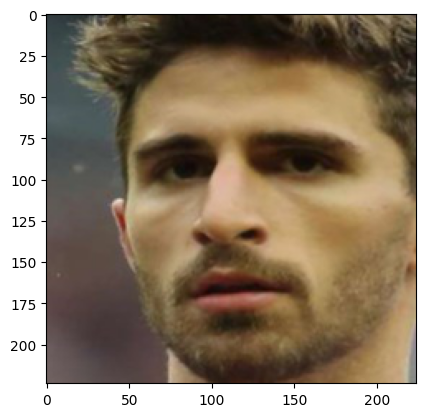

In [23]:
x_adv = None
for i in range(3):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv)
    print("class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    plt.imshow(x_adv[0].astype(np.uint8))
    plt.show(block=False)
    print(np.min(x_adv[0] - target_image), np.max(x_adv[0] - target_image))
    plt.imshow(target_image.astype(np.uint8))
    print(np.argmax(classifier.predict(np.array([target_image.astype(np.float32)]))[0]))
    print(id_targets[1])

In [24]:
splitter = StratifiedShuffleSplit(test_size=.02, n_splits=2, random_state = 7)
split = splitter.split(image_path, targets)
_, val_inds = next(split)
val_inds = val_inds[:1000]

In [25]:
all_adversarial_hsj_predicted_class = [] 
all_predicted_class = [] 
for idx, path in tqdm_notebook(enumerate(image_path[val_inds]), total=len(val_inds)):
    img = np.array(Image.open(os.path.join("../CHAPTER_13", path))).astype(np.float32)
    classifier = BlackBoxClassifier(
        predict, img.shape, num_classes, clip_values=(0, 255)
    )
    label = id_targets[idx]
    predicted_class = np.argmax(classifier.predict(np.array([img]))[0])
    attack = HopSkipJump(
        classifier=classifier, targeted=False, max_iter=10, max_eval=1000, init_eval=10, verbose=False
    )
    x_adv = None
    for i in range(3):
        x_adv = attack.generate(x=np.array([img]), x_adv_init=x_adv)
    adversarial_hsj_predicted_class = np.argmax(classifier.predict(x_adv)[0])
    if (np.min(x_adv - img) >= 10.0 or np.max(x_adv - img) >= 10.0):
        adversarial_hsj_predicted_class = predicted_class
 
 
    all_predicted_class.append(predicted_class)
    all_adversarial_hsj_predicted_class.append(adversarial_hsj_predicted_class)


/tmp/ipykernel_6990/1492268695.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for idx, path in tqdm_notebook(enumerate(image_path[val_inds]), total=len(val_inds)):


  0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
accuracy_metric = evaluate.load("accuracy")
print(accuracy_metric.compute(references=id_targets[val_inds], predictions=all_predicted_class)
print(accuracy_metric.compute(references=id_targets[val_inds], predictions=all_adversarial_ba_predicted_class)